# Train a Binary Model based on 3D Image Data and the Paper Splits

The model is based on the following paper https://arxiv.org/abs/2206.13302. However, only binary classification is performed.  
The same splits as in the paper are used. To be able to compare the new splits with the paper splits.

At the end of the notebook the calibration from the paper is compared to the current calibration.

### Import Libraries and Modules

In [23]:
#!pip install statsmodels
#!pip install seaborn

In [1]:
%matplotlib inline

import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import random

from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn import metrics
from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
print("TF  Version",tf.__version__)

TF  Version 2.2.0


In [25]:
print(os.getcwd())

/tf/notebooks/schnemau/xAI_stroke_3d


In [2]:
# check and set path before loading modules
print(os.getcwd())
DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)
#that's a cool little chunk of code to display paths
import functions_metrics as fm
import functions_model_definition as md
import functions_read_data as rdat

print("TF  Version",tf.__version__)

/tf
TF  Version 2.2.0


In [10]:
# tf.config.experimental.get_memory_usage("GPU:0")

## Load Data 


In [3]:
# Define the path + output path:
print(os.getcwd())

IMG_DIR = "/tf/notebooks/hezo/stroke_perfusion/data/" 

# IMG_DIR2 = "/tf/notebooks/kook/data-sets/stroke-lh/"
DATA_DIR = "/tf/notebooks/hezo/stroke_perfusion/data/" 
OUTPUT_DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/weights/andrea_split/"


/tf/notebooks/schnemau/xAI_stroke_3d


In [ ]:
#if not train:
#    model_3d.load_weights(OUTPUT_DIR + model_name)
#if train:
#    model_3d.load_weights(OUTPUT_DIR + model_name)
#model_3d.evaluate(x=X_test, y=y_test)

The split and model name have to be defined manually.

In [4]:
which_split = 6
# model_name = "3d_cnn_binary_model_split6_unnormalized_flatten_layer_paper_model_{epoch:03d}.h5"
model_name = "3d_cnn_binary_model_split" + str(which_split) + "_unnormalized_avg_layer_paper_model_sigmoid_activation_14.h5"
train= True #ACHTUNG

layer_connection = "globalAveragePooling"
last_activation = "sigmoid"

In [5]:
(X_train, X_valid, X_test), (y_train, y_valid, y_test), results = rdat.read_and_split_img_data_andrea(
    path_img = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5', 
    path_tab = IMG_DIR + 'baseline_data_zurich_prepared.csv', 
    path_splits = '/tf/notebooks/schnemau/xAI_stroke_3d/data/andrea_splits.csv', 
    split = which_split, 
    check_print = True)

image shape in:  (439, 128, 128, 28, 1)
image min, max, mean, std:  -0.7314910890799393 26.423200798592248 -4.100563400421584e-18 1.0
tabular shape in:  (507, 16)
split file shape in:  (407, 3)
X tab out shape:  (407, 13)
Y mrs out shape:  (407,)
End shapes X (train, val, test):  (325, 128, 128, 28) (41, 128, 128, 28) (41, 128, 128, 28)
End shapes y (train, val, test):  (325,) (41,) (41,)


In [6]:
print(np.mean(y_train))
print(np.mean(y_valid))
print(np.mean(y_test))

0.19076923076923077
0.17073170731707318
0.14634146341463414


## 3D Data Augmentation

In [7]:
# #augmentation functions

# @tf.function
# def rotate(volume):
#     """Rotate the volume by a few degrees"""

#     def scipy_rotate(volume):
#         # define some rotation angles
#         angles = [-20, -10, -5, 5, 10, 20]
#         # pick angles at random
#         angle = random.choice(angles)
#         # rotate volume
#         volume = ndimage.rotate(volume, angle, mode='nearest', reshape=False)
# #         volume[volume < 0] = 0
# #         volume[volume > 1] = 1
#         return volume

#     augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
#     return augmented_volume


# @tf.function
# def zoom(volume):
#     """Rotate the volume by a few degrees"""

#     def random_zoom3d(X_im, min_zoom = 0.85 , max_zoom = 1.15):
#         z = np.random.sample() *(max_zoom-min_zoom) + min_zoom
#         zoom_matrix = np.array([[z, 0, 0, 0],
#                             [0, z, 0, 0],
#                             [0, 0, z, 0],
#                             [0, 0, 0, 1]])
#         volume = ndimage.affine_transform(X_im, zoom_matrix, mode = "nearest", order = 1)
#         return volume

#     augmented_volume = tf.numpy_function(random_zoom3d, [volume], tf.float32)
#     return augmented_volume


# @tf.function
# def gauss(volume):
#     """Add some noise and smooth it with a gaussian filter"""

#     def random_gaussianfilter3d(X_im, sigma_max=0.2):
#         sigma = np.random.uniform(0, sigma_max)
#         volume = ndimage.gaussian_filter(X_im, sigma, mode = "nearest")
#         return volume

#     augmented_volume = tf.numpy_function(random_gaussianfilter3d, [volume], tf.float32)
#     return augmented_volume


# def train_preprocessing(volume, label):
#     """Process training data by rotating and adding a channel."""
#     # Rotate volume
#     volume = rotate(volume)
#     volume = zoom(volume)
# #     volume = gauss(volume)
#     volume = tf.expand_dims(volume, axis=3)
#     return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label



## Model

In [8]:
input_dim = np.expand_dims(X_train, axis = -1).shape[1:]
output_dim = 1

# call model
model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.summary()

Model: "cnn_3d_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 28, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 128, 128, 28, 32)  896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 64, 64, 14, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 64, 14, 32)    27680     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 32, 7, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 32, 32, 7, 64)     55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 16, 16, 3, 64)     0   

In [9]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

batch_size = 6

# Augment on the fly during training.
# train_dataset = (
#     train_loader.shuffle(len(X_train))
#     .map(train_preprocessing)
#     .batch(batch_size)
#     .prefetch(2)
# )

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.15,
    shear_range=0.15,
    fill_mode="nearest")
datagen.fit(X_train)

validation_dataset = (
    validation_loader.shuffle(len(X_valid))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

#compile
model_3d.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

# Define callbacks.
# checkpoint_cb = keras.callbacks.ModelCheckpoint(
#     OUTPUT_DIR + model_name, 
#     save_best_only=True
# )
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath = OUTPUT_DIR + "epochs/" + model_name,
    verbose = 1,
    save_weights_only = True,
    monitor = "val_loss", #'val_acc',
    mode = 'min',
    save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (325, 128, 128, 28) (28 channels).
  ' channels).')


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (325, 128, 128, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


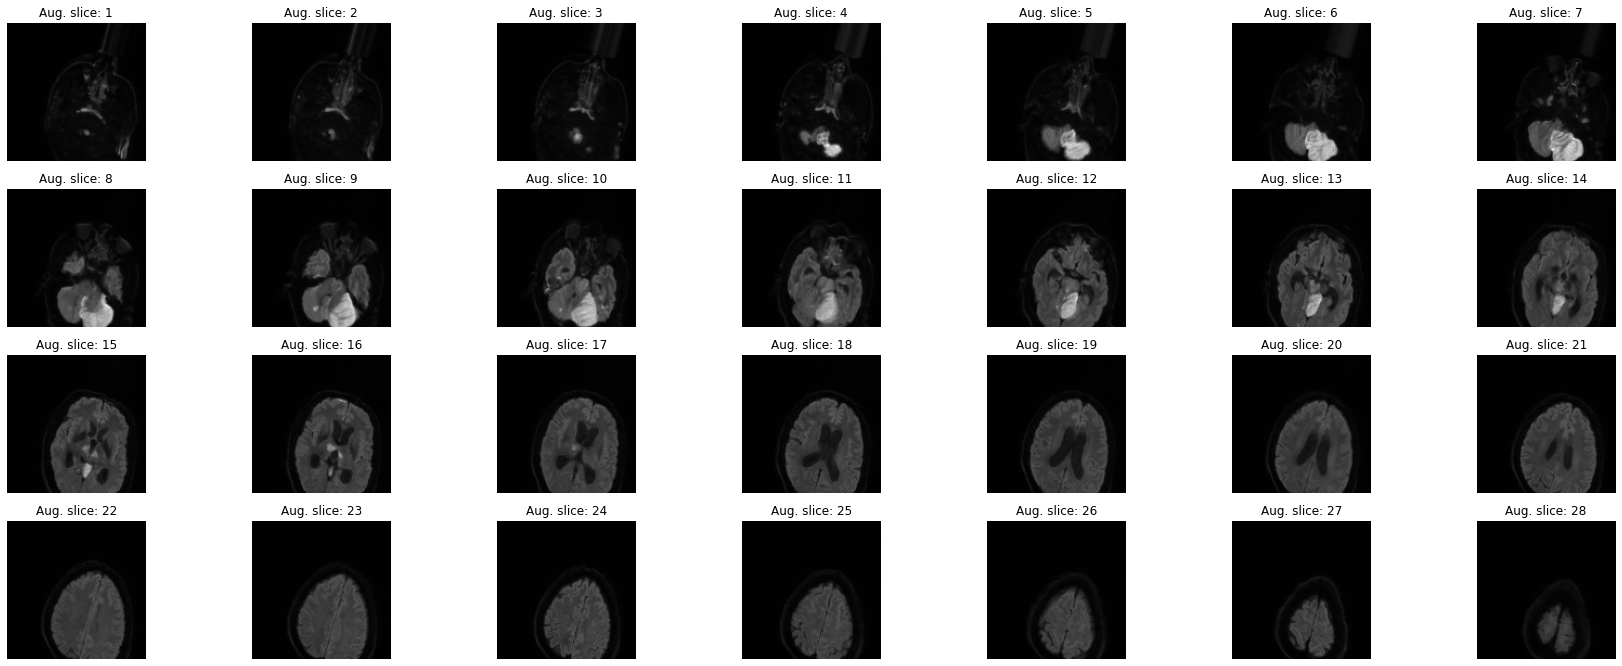

1

In [10]:
#Visualize Augemntation
# data = train_dataset.take(1)
# images, labels = list(data)[0]
# images = images.numpy()
data = datagen.flow(X_train, y_train, batch_size=batch_size)[0]
images, labels = data
image = images[0]

plt.figure(figsize=(30,30))
for i in range(image.shape[2]):
    plt.subplot(10,7,i+1)
    plt.imshow(np.squeeze(image[:, :, i]), cmap="gray", vmin = np.min(image), vmax = np.max(image))
#     plt.imshow(np.squeeze(image[:, i,: ]), cmap="gray")
    plt.axis('off')
    plt.title(str("Aug. slice: " + str(i+1)))
plt.show()

labels[0]

In [11]:
model_3d.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True),
        validation_data=validation_dataset,
        epochs=1,
        shuffle=True,
        verbose=1)

    125/Unknown - 17s 136ms/step - loss: 0.5461 - acc: 0.7932 - auc: 0.4766

KeyboardInterrupt: 

In [12]:
# Train the model, doing validation at the end of each epoch
epochs = 1

if train:
    hist = model_3d.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True),
        validation_data=validation_dataset,
        epochs=epochs,
        shuffle=True,
        verbose=1,
        callbacks=[checkpoint_cb, early_stopping_cb]
)  


     14/Unknown - 2s 130ms/step - loss: 0.4990 - acc: 0.8214 - auc: 0.4758

KeyboardInterrupt: 

NameError: name 'hist' is not defined

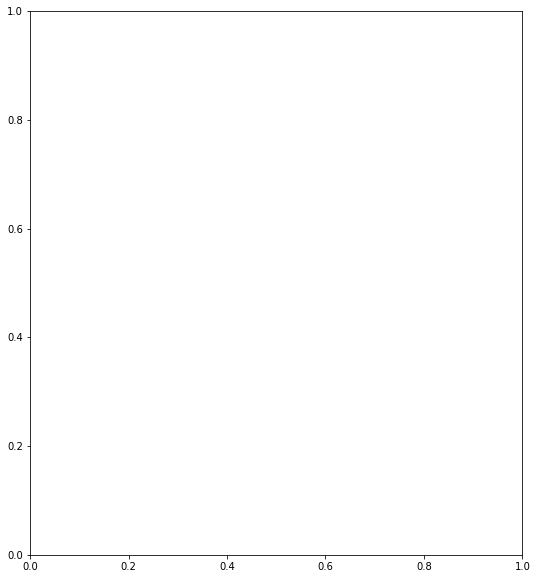

In [13]:
if train:
    plt.figure(figsize = (30,10))
    plt.subplot(1,3,1)
    plt.plot(hist.history['loss'], label = "loss")
    plt.plot(hist.history['val_loss'],label = "val_loss")
    plt.legend()
    plt.subplot(1,3,2)
    plt.plot(hist.history['acc'], label = "acc")
    plt.plot(hist.history['val_acc'],label = "val_acc")
    plt.legend()
    plt.subplot(1,3,3)
    plt.plot(hist.history['auc'], label = "auc")
    plt.plot(hist.history['val_auc'],label = "val_auc")
    plt.legend()
    plt.show()

In [33]:
if train:
    epoch_index = 55
    print(hist.history["val_loss"][epoch_index])
    print(hist.history["val_acc"][epoch_index])
    print(hist.history["val_auc"][epoch_index])

## model evaluation

In [34]:
#if not train:
#    model_3d.load_weights(OUTPUT_DIR + model_name)
#if train:
#    model_3d.load_weights(OUTPUT_DIR + model_name)
#model_3d.evaluate(x=X_test, y=y_test)

2/2 [==============================] - 2s 270ms/step - loss: 0.3279 - acc: 0.8504 - auc: 0.8205


[0.33179089426994324, 0.8536585569381714, 0.8047618865966797]

In [35]:
y_pred = model_3d.predict(X_test)
# y_pred

In [ ]:
#y_pred = fm.sigmoid(y_pred)
# y_pred

In [36]:
# model_3d.load_weights("weights/" + model_name)
fm.bin_class_report(X_test, 
                 y_test, 
                 model = model_3d)


Performance on Test Set : 

Accuracy    [95% Conf.] : 0.8537 [0.7156 0.9312]
Sensitivity [95% Conf.] : 0.1667 [0.0301 0.5635]
Specificity [95% Conf.] : 0.9714 [0.8547 0.9949]

Area under Curve (AUC) Binary [95% Conf.]: 0.569 [0.4595 0.75  ]
Area under Curve (AUC) Probability [95% Conf.]: 0.8048 [0.6316 0.9454]
Negative Log-Likelihood : 0.3318


(0.569047619047619,
 0.33179089426994324,
 0.16666666666666666,
 0.9714285714285714)

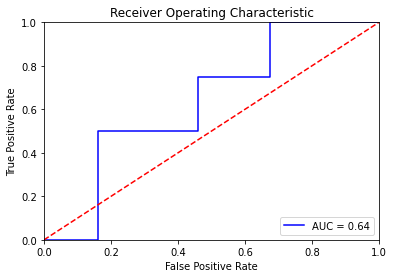

In [188]:
y_pred = model_3d.predict(X_test)

fpr, tpr, threshold = metrics.roc_curve(y_test, (y_pred))
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [189]:
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
print(threshold[index])

0.32969025


In [190]:
# acc
y_pred_label = (y_pred >= threshold[index]).squeeze()
np.mean(y_pred_label == y_test)

0.8048780487804879

In [191]:
# acc to beat
1 - np.mean(y_test)

0.9024390243902439

In [192]:
print("spezifität: ", 1-fpr[index])
print("sensitivität: ", tpr[index])

spezifität:  0.8378378378378378
sensitivität:  0.5


In [193]:
results["pred_prob"] = y_pred.squeeze()

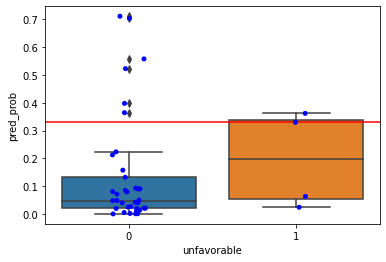

In [194]:
import seaborn as sns

sns.boxplot(x = "unfavorable",
            y = "pred_prob",
            data = results)
sns.stripplot(x = "unfavorable",
              y = "pred_prob",
              color = 'blue',
              data = results)
plt.axhline(y = threshold[index], color = "red")

## Calibration Plots and Result Comparision

In [195]:
y_pred = model_3d.predict(X_test)
y_pred = y_pred.squeeze()
print(np.min(y_pred), np.max(y_pred))

0.00056121603 0.7103981


In [196]:
cal_plot_data = fm.cal_plot_data_prep(y_pred, y_test)
cal_plot_data

,predicted_probability_mean,predicted_probability_middle,observed_proportion,observed_proportion_lower,observed_proportion_upper,observed_cases,bin_cuts
0,0.008689,0.010673,0.000000,0.000000,0.277533,0,[0. 0.0213]
1,0.033884,0.035745,0.100000,0.017876,0.404150,1,[0.0213 0.0501]
2,0.083612,0.103929,0.100000,0.017876,0.404150,1,[0.0501 0.1577]
3,0.412661,0.578857,0.181818,0.051368,0.476981,2,[0.1577 1. ]


Plot current model calibration

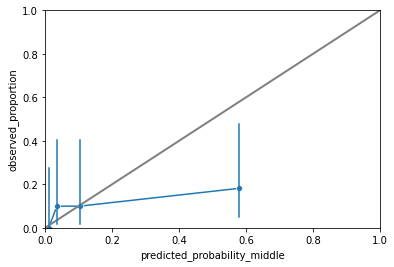

In [197]:
fm.cal_plot(cal_plot_data, "predicted_probability_middle", "observed_proportion",
                        "observed_proportion_lower", "observed_proportion_upper")

### Load Andreas Results

In [198]:
andrea_result_path = "/tf/notebooks/kook/dtm-usz-stroke/intermediate-results/"
andrea_results_ens1 = pd.read_csv(
    andrea_result_path + 'raw-results/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl' + str(which_split) + '_ens1.csv'
    ).rename(columns={"Unnamed: 0": "p_idx"})
andrea_results_ens2 = pd.read_csv(
    andrea_result_path + 'raw-results/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl' + str(which_split) + '_ens2.csv'
    ).rename(columns={"Unnamed: 0": "p_idx"})
andrea_results_ens3 = pd.read_csv(
    andrea_result_path + 'raw-results/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl' + str(which_split) + '_ens3.csv'
    ).rename(columns={"Unnamed: 0": "p_idx"})
andrea_results_ens4 = pd.read_csv(
    andrea_result_path + 'raw-results/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl' + str(which_split) + '_ens4.csv'
    ).rename(columns={"Unnamed: 0": "p_idx"})
andrea_results_ens5 = pd.read_csv(
    andrea_result_path + 'raw-results/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl' + str(which_split) + '_ens5.csv'
    ).rename(columns={"Unnamed: 0": "p_idx"})

In [199]:
results["andrea_pred_prob_ens1"] = 1-andrea_results_ens1["V2"]
results["andrea_pred_prob_ens2"] = 1-andrea_results_ens2["V2"]
results["andrea_pred_prob_ens3"] = 1-andrea_results_ens2["V2"]
results["andrea_pred_prob_ens4"] = 1-andrea_results_ens2["V2"]
results["andrea_pred_prob_ens5"] = 1-andrea_results_ens2["V2"]

results.head()

,p_idx,p_id,mrs,unfavorable,pred_prob,andrea_pred_prob_ens1,andrea_pred_prob_ens2,andrea_pred_prob_ens3,andrea_pred_prob_ens4,andrea_pred_prob_ens5
0,181,239.0,2.0,0,0.005486,0.003652,0.002127,0.002127,0.002127,0.002127
1,3,3.0,0.0,0,0.212511,0.404884,0.285708,0.285708,0.285708,0.285708
2,371,515.0,2.0,0,0.010038,0.006506,0.009470,0.009470,0.009470,0.009470
3,49,63.0,0.0,0,0.364075,0.055505,0.043883,0.043883,0.043883,0.043883
4,159,215.0,2.0,0,0.042183,0.019665,0.016339,0.016339,0.016339,0.016339


In [200]:
np.mean(y_test)

0.0975609756097561

### Compare Results

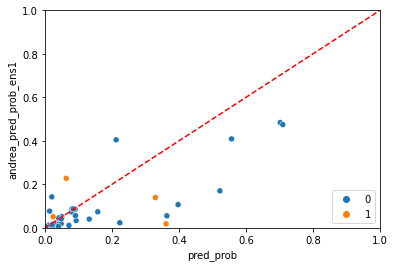

In [201]:
g = sns.scatterplot(data=results, x="pred_prob", y="andrea_pred_prob_ens1", hue = "unfavorable")
plt.legend(loc='lower right')
g.set(ylim=(0, 1), xlim=(0,1))
g.plot([0,1], [0,1], "r--")

### Calipration Plot: all of Andrea vs. current split

In [45]:
# andrea_calplot_dat = pd.read_csv('/tf/notebooks/brdd/xAI_stroke_3d/data/bincal_avgnll.csv')
andrea_calplot_dat = pd.read_csv("/tf/notebooks/kook/dtm-usz-stroke/intermediate-results/"
 + 'bincal_avgnll.csv')
andrea_calplot_cibinary_avg = andrea_calplot_dat[(andrea_calplot_dat["mod"] == "cimrsbinary") &
                                                 (andrea_calplot_dat["method"] == "trafo") &
                                                (andrea_calplot_dat["weights"] == "equal")]
andrea_calplot_cibinary_avg
# cal_plot(andrea_calplot_cibinary_avg, "midpoint", "prop", "lwr", "upr")

,Unnamed: 0,bin,prop,lwr,upr,cases,midpoint,method,mod,weights
108,109,NaN,0.030303,0.000766,0.327536,0.333333,0.024017,trafo,cimrsbinary,equal
109,110,NaN,0.083333,0.005466,0.418023,0.833333,0.062701,trafo,cimrsbinary,equal
110,111,NaN,0.250000,0.053544,0.598091,2.500000,0.109624,trafo,cimrsbinary,equal
111,112,NaN,0.266667,0.058252,0.616015,2.666667,0.570940,trafo,cimrsbinary,equal


In [46]:
andrea_calplot_dat_spl = pd.read_csv('/tf/notebooks/schnemau/xAI_stroke_3d/data/bincal_splnll.csv')
andrea_calplot_cibinary_spl = andrea_calplot_dat_spl[(andrea_calplot_dat_spl["mod"] == "cimrsbinary") &
                                                     (andrea_calplot_dat_spl["method"] == "trafo") &
                                                     (andrea_calplot_dat_spl["weights"] == "equal")]


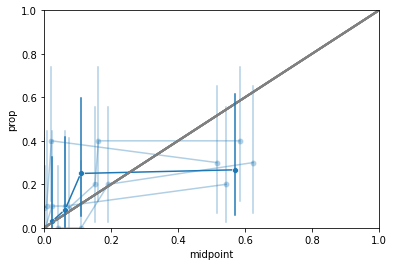

In [48]:
# plt.figure(figsize=(4, 4))
for i in range(5):
    fm.cal_plot(andrea_calplot_cibinary_spl[andrea_calplot_cibinary_spl["spl"] == i], 
             "midpoint", "prop", "lwr", "upr", alpha = .35, show = False)
fm.cal_plot(andrea_calplot_cibinary_avg, "midpoint", "prop", "lwr", "upr", show = False)


The blue lines are from the paper. The thick blue line is the mean model of the paper.
In orange is the current model.